In [1]:
#!pip install -U datasets

In [2]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random

from datasets import load_dataset

In [3]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [5]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)}
itol = {i: l for l, i in ltoi.items()}

In [6]:
model_checkpoint = "microsoft/deberta-v3-base" # Or deberta-v3-large, etc.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Check if the tokenizer is a fast tokenizer (it should be for DeBERTa-v3)
assert tokenizer.is_fast, "Only fast tokenizers are supported for this example."

/user/HS400/rh01555/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True, # Crucial for pre-tokenized input
        max_length=512,
        padding="max_length"
    )

    labels = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None: # Special tokens ([CLS], [SEP])
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # First token of a new word
                label_ids.append(ltoi[label_sequence[word_idx]])
            else: # Subsequent tokens of the same word
                label_ids.append(-100)


            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
t = tokenizer(["Dr. House administered the CPR."])
print(t.input_ids)
print(t.word_ids(0))

[[1, 1011, 260, 1097, 10028, 262, 20715, 260, 2]]
[None, 0, 0, 1, 2, 3, 4, 4, None]


In [9]:
data = dataset.map(tokenize_and_align_labels, batched = True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [10]:
train_data, train_labels, train_attention_mask = data['train']['input_ids'], data['train']['labels'], data['train']['attention_mask']
val_data, val_labels, val_attention_mask = data['validation']['input_ids'], data['validation']['labels'], data['validation']['attention_mask']
test_data, test_labels, test_attention_mask = data['test']['input_ids'], data['test']['labels'], data['test']['attention_mask']

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

def get_batch(split = "train"):
  data = train_data if split == "train" else val_data
  labels = train_labels if split == "train" else val_labels
  attention_mask = train_attention_mask if split == "train" else val_attention_mask
  ix = torch.randint(len(data), (batch_size,))
  x = torch.stack([torch.tensor(data[i]).long() for i in ix])
  y = torch.stack([torch.tensor(labels[i]).long() for i in ix])
  a = torch.stack([torch.tensor(attention_mask[i]) for i in ix])
  return x.to(device), y.to(device), a.to(device)


@torch.no_grad()
def estimate_loss(eval_steps):
    out = {}
    model.eval()
    
    for split in ["train", "validation"]:
        losses = torch.zeros(eval_steps)
        correct_tokens = 0
        total_tokens = 0

        for k in range(eval_steps):
            x, y, a = get_batch(split)
            logits = model(x, attention_mask=a).logits
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
            losses[k] = loss.item()

            # Accuracy calculation
            preds = logits.argmax(dim=-1)
            mask = (y != -100)  # optional: ignore padding label if using -100
            correct = (preds == y) & mask
            correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

        avg_loss = losses.mean().item()
        avg_acc = correct_tokens / total_tokens if total_tokens > 0 else 0.0
        out[split] = {"loss": avg_loss, "accuracy": avg_acc}

    model.train()
    return out


In [12]:
def train_model(model, optimizer):
    train_loss_step = []
    train_acc_step = []
    val_loss_step = []
    val_acc_step = []
    eval_step = []

    max_steps = 1000

    for step in range(max_steps):
        x, y, a = get_batch("train")
        optimizer.zero_grad()
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(x, attention_mask=a).logits
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            # Validation step
            metrics = estimate_loss(200)
            print(f"step {step}: "
                  f"train loss {metrics['train']['loss']:.4f}, acc {metrics['train']['accuracy']:.4f} | "
                  f"val loss {metrics['validation']['loss']:.4f}, acc {metrics['validation']['accuracy']:.4f}")
            train_loss_step.append(metrics['train']['loss'])
            train_acc_step.append(metrics['train']['accuracy'])
            val_loss_step.append(metrics['validation']['loss'])
            val_acc_step.append(metrics['validation']['accuracy'])
            eval_step.append(step)

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_step, train_loss_step, label='Train Loss')
    plt.plot(eval_step, val_loss_step, label='Val Loss')
    plt.legend()
    plt.title("Loss over Steps")

    plt.subplot(1, 2, 2)
    plt.plot(eval_step, train_acc_step, label='Train Acc')
    plt.plot(eval_step, val_acc_step, label='Val Acc')
    plt.legend()
    plt.title("Accuracy over Steps")

    plt.show()

    return model

In [13]:
torch.set_float32_matmul_precision("high")

In [14]:
@torch.no_grad()
def evaluate_model(model, split="test"):
    """Evaluate model performance on given split with seqeval metrics"""
    model.eval()
    
    if split == "test":
        data_input_ids = test_data
        data_labels = test_labels
        data_attention_mask = test_attention_mask
    elif split == "validation":
        data_input_ids = val_data
        data_labels = val_labels
        data_attention_mask = val_attention_mask
    else:
        data_input_ids = train_data
        data_labels = train_labels
        data_attention_mask = train_attention_mask
    
    # Process in smaller batches to avoid OOM
    batch_size_eval = 16
    all_true_labels = []
    all_pred_labels = []
    
    # Process the entire dataset
    for i in tqdm(range(0, len(data_input_ids), batch_size_eval), desc=f"Evaluating on {split}"):
        # Get batch
        batch_input_ids = torch.tensor(data_input_ids[i:i+batch_size_eval]).to(device)
        batch_labels = torch.tensor(data_labels[i:i+batch_size_eval]).to(device)
        batch_attention_mask = torch.tensor(data_attention_mask[i:i+batch_size_eval]).to(device)
        
        # Get predictions
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # Convert predictions and labels to lists for seqeval
        for j in range(len(batch_input_ids)):
            true_label_ids = batch_labels[j].cpu().numpy()
            pred_label_ids = predictions[j].cpu().numpy()
            
            # Convert IDs to labels, handling special tokens
            true_seq = []
            pred_seq = []
            
            for true_id, pred_id, mask in zip(true_label_ids, pred_label_ids, batch_attention_mask[j]):
                if mask == 1 and true_id != -100:  # Only evaluate on non-padding and non-special tokens
                    true_seq.append(itol[true_id.item()])
                    pred_seq.append(itol[pred_id.item()])
            
            if true_seq:  # Only add if not empty
                all_true_labels.append(true_seq)
                all_pred_labels.append(pred_seq)
    
    # Calculate metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    report = classification_report(all_true_labels, all_pred_labels)
    
    print(f"\n=== Evaluation on {split} split ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nDetailed Classification Report:")
    print(report)

    flat_true = [ltoi[l] for seq in all_true_labels for l in seq]
    flat_pred = [ltoi[l] for seq in all_true_labels for l in seq]

    cm = confusion_matrix(flat_true, flat_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(8, 6))  # <-- Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "report": report
    }

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


step 0: train loss 0.9520, acc 0.7571 | val loss 0.9985, acc 0.7404
step 100: train loss 0.8054, acc 0.7612 | val loss 0.8311, acc 0.7476
step 200: train loss 0.8135, acc 0.7610 | val loss 0.8357, acc 0.7509
step 300: train loss 0.8135, acc 0.7621 | val loss 0.8354, acc 0.7478
step 400: train loss 0.8178, acc 0.7550 | val loss 0.8357, acc 0.7434
step 500: train loss 0.7882, acc 0.7580 | val loss 0.8311, acc 0.7346
step 600: train loss 0.8041, acc 0.7578 | val loss 0.8318, acc 0.7401
step 700: train loss 0.7841, acc 0.7625 | val loss 0.8250, acc 0.7440
step 800: train loss 0.8360, acc 0.7528 | val loss 0.8572, acc 0.7415
step 900: train loss 0.8281, acc 0.7528 | val loss 0.8644, acc 0.7335


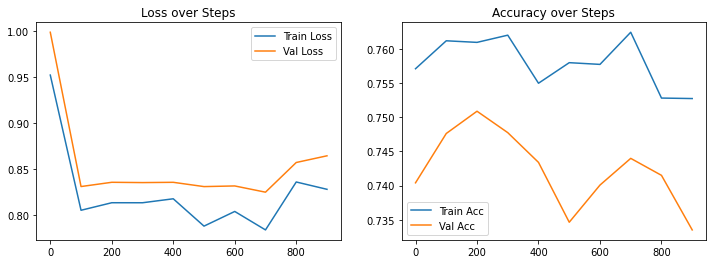

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s]
/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS400/rh01555/.local/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control t


=== Evaluation on test split ===
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.00      0.00      0.00       797
          LF       0.00      0.00      0.00       482

   micro avg       0.00      0.00      0.00      1279
   macro avg       0.00      0.00      0.00      1279
weighted avg       0.00      0.00      0.00      1279



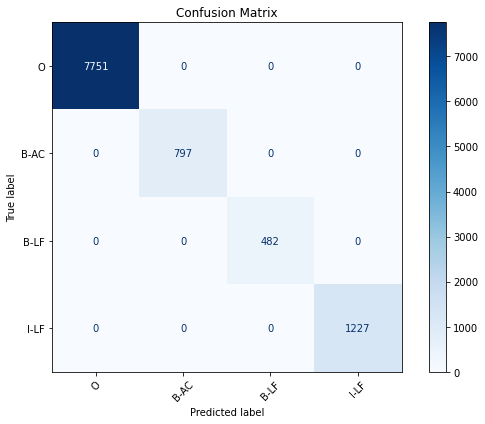

In [15]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.AdamW(model.parameters(), lr = 3e-4)
model = train_model(model, optim)
out = evaluate_model(model)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


step 0: train loss 1.2178, acc 0.4078 | val loss 1.2237, acc 0.4126
step 100: train loss 0.7198, acc 0.7694 | val loss 0.7452, acc 0.7501
step 200: train loss 0.6243, acc 0.7903 | val loss 0.6411, acc 0.7730
step 300: train loss 0.5381, acc 0.8192 | val loss 0.5549, acc 0.7983
step 400: train loss 0.4990, acc 0.8266 | val loss 0.5194, acc 0.8073
step 500: train loss 0.4453, acc 0.8437 | val loss 0.4767, acc 0.8222
step 600: train loss 0.4285, acc 0.8437 | val loss 0.4464, acc 0.8238
step 700: train loss 0.3883, acc 0.8569 | val loss 0.4188, acc 0.8350
step 800: train loss 0.3796, acc 0.8570 | val loss 0.4071, acc 0.8408
step 900: train loss 0.3531, acc 0.8712 | val loss 0.3848, acc 0.8495


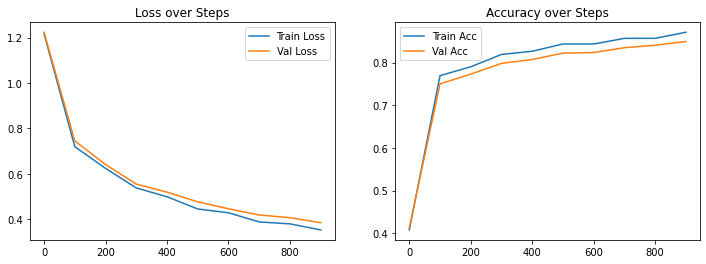

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.65it/s]



=== Evaluation on test split ===
F1 Score: 0.6611
Precision: 0.6712
Recall: 0.6513

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.87      0.71      0.78       797
          LF       0.46      0.56      0.50       482

   micro avg       0.67      0.65      0.66      1279
   macro avg       0.66      0.63      0.64      1279
weighted avg       0.71      0.65      0.67      1279



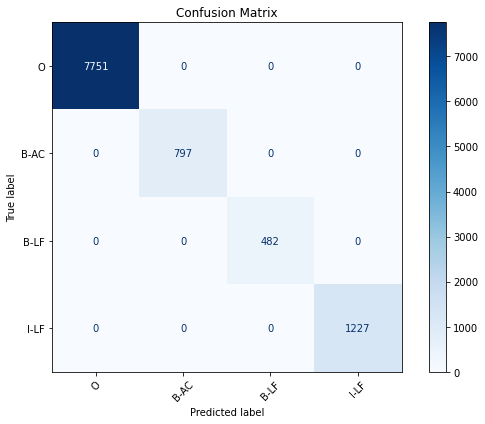

In [16]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.SGD(model.parameters(), lr = 3e-4)
model = train_model(model, optim)
out = evaluate_model(model)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


step 0: train loss 1.2268, acc 0.7563 | val loss 1.3355, acc 0.7353
step 100: train loss 0.2017, acc 0.9262 | val loss 0.2426, acc 0.9099
step 200: train loss 0.1655, acc 0.9376 | val loss 0.2370, acc 0.9169
step 300: train loss 0.1522, acc 0.9438 | val loss 0.2307, acc 0.9210
step 400: train loss 0.1303, acc 0.9501 | val loss 0.2390, acc 0.9131
step 500: train loss 0.1181, acc 0.9609 | val loss 0.2303, acc 0.9189
step 600: train loss 0.0962, acc 0.9674 | val loss 0.2487, acc 0.9159
step 700: train loss 0.0910, acc 0.9689 | val loss 0.2736, acc 0.9168
step 800: train loss 0.1089, acc 0.9616 | val loss 0.2580, acc 0.9170
step 900: train loss 0.0845, acc 0.9708 | val loss 0.2862, acc 0.9151


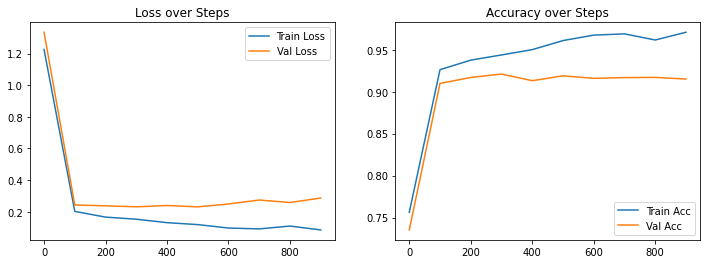

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.60it/s]



=== Evaluation on test split ===
F1 Score: 0.8458
Precision: 0.8342
Recall: 0.8577

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.90      0.89      0.90       797
          LF       0.74      0.80      0.77       482

   micro avg       0.83      0.86      0.85      1279
   macro avg       0.82      0.85      0.83      1279
weighted avg       0.84      0.86      0.85      1279



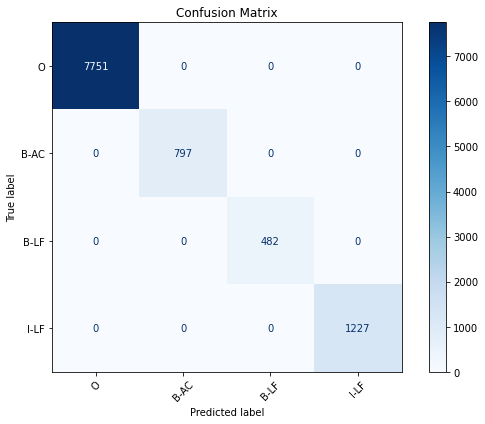

In [17]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.RMSprop(model.parameters(), lr = 3e-5)
model = train_model(model, optim)
out = evaluate_model(model)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


step 0: train loss 1.6080, acc 0.2407 | val loss 1.6009, acc 0.2530
step 100: train loss 0.2131, acc 0.9184 | val loss 0.2744, acc 0.8983
step 200: train loss 0.1699, acc 0.9427 | val loss 0.2689, acc 0.9120
step 300: train loss 0.1386, acc 0.9485 | val loss 0.2185, acc 0.9174
step 400: train loss 0.1314, acc 0.9517 | val loss 0.2388, acc 0.9163
step 500: train loss 0.1246, acc 0.9570 | val loss 0.2570, acc 0.9174
step 600: train loss 0.1352, acc 0.9514 | val loss 0.2924, acc 0.9048
step 700: train loss 0.1054, acc 0.9586 | val loss 0.2186, acc 0.9210
step 800: train loss 0.0982, acc 0.9621 | val loss 0.2562, acc 0.9170
step 900: train loss 0.0754, acc 0.9725 | val loss 0.2544, acc 0.9170


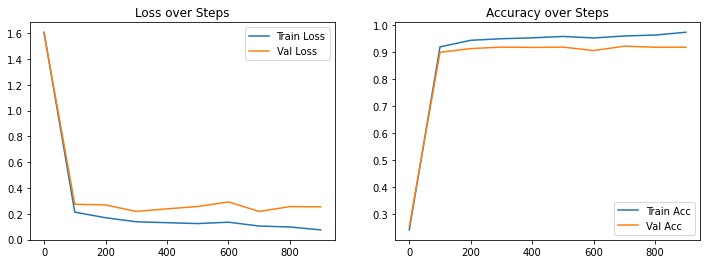

Evaluating on test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.66it/s]



=== Evaluation on test split ===
F1 Score: 0.8698
Precision: 0.8153
Recall: 0.9320

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.85      0.95      0.89       797
          LF       0.76      0.91      0.83       482

   micro avg       0.82      0.93      0.87      1279
   macro avg       0.81      0.93      0.86      1279
weighted avg       0.82      0.93      0.87      1279



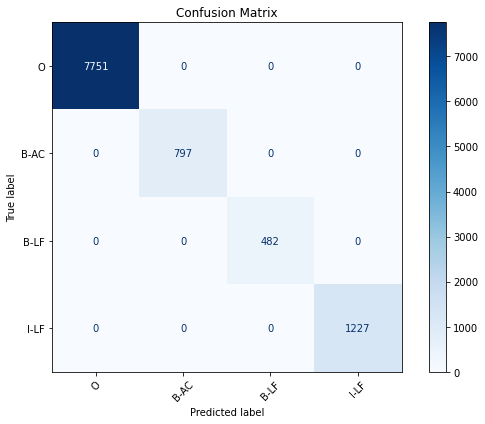

In [18]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)
model = torch.compile(model)

optim = torch.optim.AdamW(model.parameters(), lr = 3e-5)
model = train_model(model, optim)
out = evaluate_model(model)